In [1]:
# Convolutional Neural Network
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Download training sets as tensors
trainset = torchvision.datasets.SVHN(
    root='./datasets', 
    split='train', 
    download=True, 
    transform=transforms.ToTensor()
)

Using downloaded and verified file: ./datasets\train_32x32.mat


In [3]:
# load data into the training set in batches
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=8,
    shuffle=True,
    num_workers=2
)

In [4]:
# Download testing sets as tensors
testset = torchvision.datasets.SVHN(
    root='./datasets', 
    split='test', 
    download=True, 
    transform=transforms.ToTensor()
)

Using downloaded and verified file: ./datasets\test_32x32.mat


In [5]:
# load data into the testing set in batches. shuffle=False because it is not training.
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=8,
    shuffle=False,
    num_workers=2
)

In [6]:
# load images in by calling .next() on our trainloader
images_batch, target_batch = iter(trainloader).next()

In [7]:
# number of batches is 8, numbers of channels is 3 (color images), 32 x 32 images
images_batch.shape

torch.Size([8, 3, 32, 32])

In [8]:
# Use a torchvision utility to make a grid of images in this batch
img = torchvision.utils.make_grid(images_batch)

In [9]:
# 3 channels, 36 pixels high, 274 pixels wide because 8 images X 36px
img.shape

torch.Size([3, 36, 274])

In [10]:
# in order to plot images in matplotlib the number of channels should be the last dimension
# use the transpose function to change order of dimensions
np.transpose(img, (1,2,0)).shape

torch.Size([36, 274, 3])

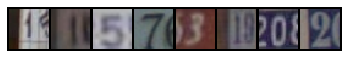

In [11]:
plt.imshow(np.transpose(img, (1,2,0)))
plt.axis('off')
plt.show()

In [12]:
in_size = 3 # input size is 3 channels
hid1_size = 16 # 1st convolution layer output is 16 feature maps
hid2_size = 32 # 2nd convolution layer output is 32 feature maps
out_size = 10 # the number of categorizes in our classification
k_conv_size = 5 # 5x5 conv kernel for our conv layers

In [13]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_size, hid1_size, k_conv_size), 
            nn.BatchNorm2d(hid1_size),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(hid1_size, hid2_size, k_conv_size), 
            nn.BatchNorm2d(hid2_size),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2))
        
        self.fc = nn.Linear(
            hid2_size * k_conv_size * k_conv_size, out_size)
        
    def forward(self, x):
            out = self.layer1(x)
            out = self.layer2(out)
            out = out.reshape(out.size(0), -1)
            out = self.fc(out)
            
            return out # would normally output softmax layer

In [14]:
model = ConvNet()

In [15]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate)

In [17]:
total_step = len(trainloader)
num_epochs = 5

for epoch in range(num_epochs):
    for i, (images, targets) in enumerate(trainloader):
        
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 2000 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [2000/9158], Loss: 0.1006
Epoch [1/5], Step [4000/9158], Loss: 1.1377
Epoch [1/5], Step [6000/9158], Loss: 0.3345
Epoch [1/5], Step [8000/9158], Loss: 0.7365
Epoch [2/5], Step [2000/9158], Loss: 1.1060
Epoch [2/5], Step [4000/9158], Loss: 0.3035
Epoch [2/5], Step [6000/9158], Loss: 0.0944
Epoch [2/5], Step [8000/9158], Loss: 0.3644
Epoch [3/5], Step [2000/9158], Loss: 1.5336
Epoch [3/5], Step [4000/9158], Loss: 0.0222
Epoch [3/5], Step [6000/9158], Loss: 0.1543
Epoch [3/5], Step [8000/9158], Loss: 0.1517
Epoch [4/5], Step [2000/9158], Loss: 0.2523
Epoch [4/5], Step [4000/9158], Loss: 0.1606
Epoch [4/5], Step [6000/9158], Loss: 0.2783
Epoch [4/5], Step [8000/9158], Loss: 0.4436
Epoch [5/5], Step [2000/9158], Loss: 0.1336
Epoch [5/5], Step [4000/9158], Loss: 0.0068
Epoch [5/5], Step [6000/9158], Loss: 0.0206
Epoch [5/5], Step [8000/9158], Loss: 0.0645


In [18]:
# set model to evaluation or prediction mode
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, targets in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (
            predicted == targets).sum().item()
    print('Accuracy of the model on the test images: {}%'.format(
        100 * correct / total))

Accuracy of the model on the test images: 88.27980946527352%
